In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change, rho_A_t_fn, cum_A_t_fn
from tqdm import tqdm


# data

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [3]:
df_to_fit = df[ df['LED_trial'] == 1 ] 

# VBMC

In [4]:
T_trunc = 0.3

In [ ]:


def compute_loglike(row, base_V_A, new_V_A, theta_A, t_A_aff):
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_led = row['intended_fix'] - row['LED_onset_time']

    
    if rt < T_trunc:
        likelihood = 0
    else:
        if t_led == 0: # only new V_A will be used
            pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
            if rt < t_stim:
                likelihood =  rho_A_t_fn(rt - t_A_aff, new_V_A, theta_A) / pdf_trunc_factor
            elif rt > t_stim:
                likelihood = ( 1 - cum_A_t_fn(t_stim - t_A_aff, new_V_A, theta_A) ) / pdf_trunc_factor
        else: # V_A change in middle
            trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff, base_V_A, new_V_A, theta_A, t_led)
            if rt < t_stim:
                likelihood = PDF_hit_V_A_change(rt-t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
            elif rt > t_stim:
                likelihood = ( 1 - CDF_hit_V_A_change(t_stim - t_A_aff, base_V_A, new_V_A, theta_A, t_led) ) / trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    base_V_A, new_V_A, theta_A, t_A_aff = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, base_V_A, new_V_A, theta_A, t_A_aff)\
                                      for _, row in df_to_fit.iterrows() \
                                        if (not np.isnan(row['timed_fix'] + row['intended_fix'] + row['LED_onset_time']))) 
                                   

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [6]:
base_V_A_bounds = [0.1, 5]
new_V_A_bounds = [0.1, 5]
theta_A_bounds = [0.1, 5]
t_A_aff_bounds = [-5, 0.1]

base_V_A_plausible_bounds = [0.5, 3]
new_V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [0.5, 3]
t_A_aff_plausible_bounds = [-2, 0.06]

# prior

In [7]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    base_V_A, new_V_A, theta_A, t_A_aff = params

    base_V_A_logpdf = trapezoidal_logpdf(base_V_A, base_V_A_bounds[0], base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1], base_V_A_bounds[1])
    new_V_A_logpdf = trapezoidal_logpdf(new_V_A, new_V_A_bounds[0], new_V_A_plausible_bounds[0], new_V_A_plausible_bounds[1], new_V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return base_V_A_logpdf + new_V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# joint

In [8]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [9]:
lb = [base_V_A_bounds[0], new_V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [base_V_A_bounds[1], new_V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]

plb = [base_V_A_plausible_bounds[0], new_V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [base_V_A_plausible_bounds[1], new_V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
base_V_A_0 = np.random.uniform(base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1])
new_V_A_0 = np.random.uniform(new_V_A_plausible_bounds[0], new_V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([base_V_A_0, new_V_A_0, theta_A_0, t_A_aff_0])

In [10]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -153978.179 +/-0.047.


In [13]:
# save vbmc
vp.save('V_A_step_jump_LED_on_vbmc.pkl')

In [5]:
import pickle
with open('V_A_step_jump_LED_on_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

# corner plot

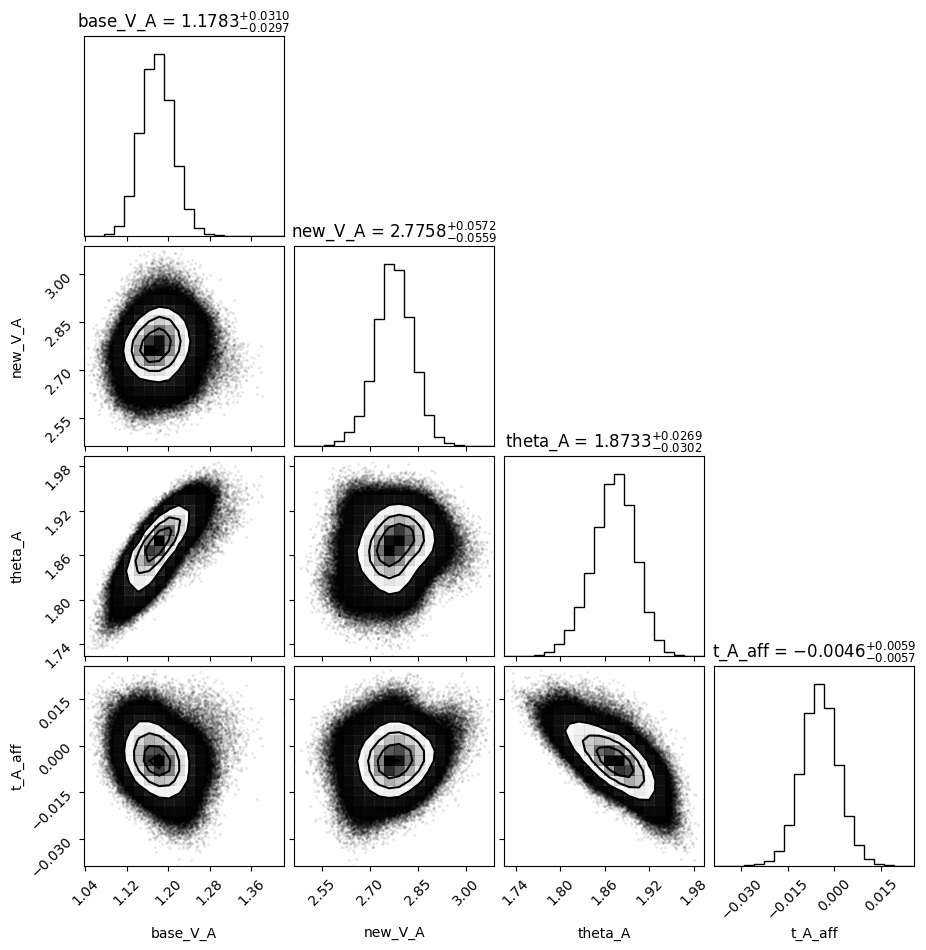

In [6]:
import corner
vp_samples = vp.sample(int(1e6))[0]
base_V_A_samp = vp_samples[:,0]
new_V_A_samp = vp_samples[:,1]
theta_A_samp = vp_samples[:,2]
t_A_aff_samp = vp_samples[:,3]

combined_samples = np.transpose(np.vstack((base_V_A_samp, new_V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['base_V_A', 'new_V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f");


# fit and see - all

In [7]:
base_V_A_mean = np.mean(base_V_A_samp)
new_V_A_mean = np.mean(new_V_A_samp)
theta_A_mean = np.mean(theta_A_samp)
t_A_aff_mean = np.mean(t_A_aff_samp)

In [86]:
# data
data_abort_rt = df_to_fit[ (df_to_fit['timed_fix'] < df_to_fit['intended_fix']) & \
                            (df_to_fit['timed_fix'] > T_trunc) ]['timed_fix'].values

bin_width = 0.03
bins = np.arange(0, np.max(data_abort_rt), bin_width)
t_pts = bins[:-1] + bin_width / 2

frac_of_aborts_data = len(data_abort_rt) / len(df_to_fit)
print(f'frac of aborts = {frac_of_aborts_data}')

frac of aborts = 0.1515062454077884


In [104]:
def calc_trunc_pdf(t, base_V_A, new_V_A, theta_A, t_A_aff, t_led, trunc_factor):   
    # pdf
    if t_led == 0:
        if t <= T_trunc:
            pdf = 0
        else:
            trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
            pdf = rho_A_t_fn(t - t_A_aff, new_V_A, theta_A) / trunc_factor
    else:
        if t <= T_trunc:
            pdf = 0
        else:
            pdf = PDF_hit_V_A_change(t - t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
    return pdf

def calc_trunc_cdf(base_V_A, new_V_A, theta_A, t_A_aff, t_led, t_stim, trunc_factor):
    # cdf
    if t_stim <= T_trunc:
        return 0
    if t_led == 0:
        trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
        cdf = cum_A_t_fn(t_stim - t_A_aff, new_V_A, theta_A) / trunc_factor
    else:
        cdf = (CDF_hit_V_A_change(t_stim - t_A_aff, base_V_A, new_V_A, theta_A, t_led)) / trunc_factor
    return cdf


In [105]:
N_theory = 5000
unique_pairs = list(zip(df_to_fit['intended_fix'], df_to_fit['intended_fix'] - df_to_fit['LED_onset_time']))
sampled_pairs = random.sample(unique_pairs, min(N_theory, len(unique_pairs)))

pdf_ensemble = np.zeros((N_theory, len(t_pts)))
cdf_ensemble = np.zeros((N_theory, ))
all_areas_pdf_ensemble = np.zeros((N_theory, ))
for i, (t_stim, t_led) in tqdm(enumerate (sampled_pairs), total=N_theory):
    if t_stim <= t_led:
        print('Issue')
        break
    
    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_mean, base_V_A_mean, new_V_A_mean, theta_A_mean, t_led)
    pdf_ensemble[i,:] = [calc_trunc_pdf(t, base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, trunc_factor) for t in t_pts]
    all_areas_pdf_ensemble[i] = np.trapz(pdf_ensemble[i,:], t_pts)
    # if all_areas_pdf_ensemble[i] < 0.8:
    #     print(f'params = {t_stim, t_led}')
    
    cdf_ensemble[i] = calc_trunc_cdf(base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, t_stim, trunc_factor)
    # if cdf_ensemble[i] > 0.2:
    #     print(f'params = {t_stim, t_led}')


100%|██████████| 5000/5000 [03:06<00:00, 26.87it/s]


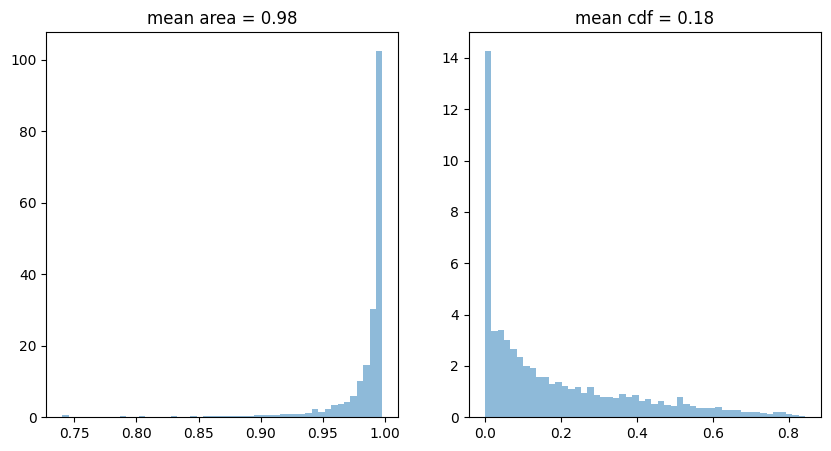

In [107]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(all_areas_pdf_ensemble, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean area = {np.mean(all_areas_pdf_ensemble):.2f}');

plt.subplot(1,2,2)
plt.hist(cdf_ensemble, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean cdf = {np.mean(cdf_ensemble):.2f}');

In [108]:
# sanity checks
cdf_ensemble_mean = np.mean(cdf_ensemble)
pdf_ensemble_mean = np.mean(pdf_ensemble, axis=0)
print(f'pdf ensemble mean shape = {pdf_ensemble_mean.shape}')
print(f'frac aborts theory = {cdf_ensemble_mean}, frac aborts data = {frac_of_aborts_data}')
print(f'area under pdf ensemble mean = {np.trapz(pdf_ensemble_mean, t_pts)}')

pdf ensemble mean shape = (66,)
frac aborts theory = 0.1809635136336708, frac aborts data = 0.1515062454077884
area under pdf ensemble mean = 0.9811111137315945


In [109]:
abort_rt_hist, _ = np.histogram(data_abort_rt, bins=bins, density=True)
abort_rt_hist *= frac_of_aborts_data # to make area frac of aborts


pdf_ensemble_mean_norm = pdf_ensemble_mean* cdf_ensemble_mean # so that area is frac of aborts

area under theory = 0.17754531440591337, area under data = 0.1514915474794407


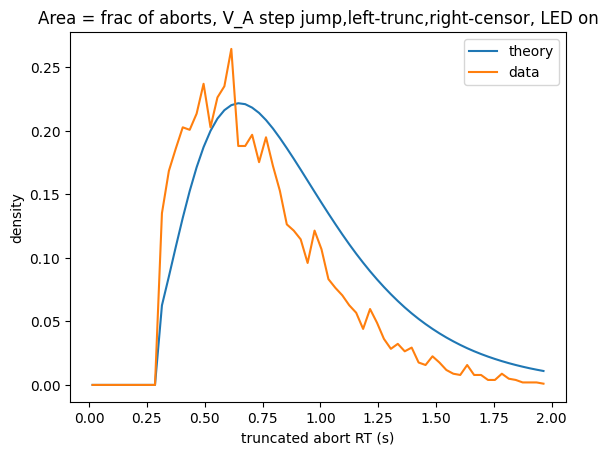

In [110]:
plt.plot(t_pts, pdf_ensemble_mean_norm, label='theory')
plt.plot(t_pts, abort_rt_hist, label='data')

plt.legend()

plt.xlabel('truncated abort RT (s)')
plt.ylabel('density')
plt.title('Area = frac of aborts, V_A step jump,left-trunc,right-censor, LED on')
print(f'area under theory = {np.trapz(pdf_ensemble_mean_norm, t_pts)}, area under data = {np.trapz(abort_rt_hist, t_pts)}')

Text(0.5, 1.0, 'Area = 1,V_A step jump,left-trunc,right-censor, LED on')

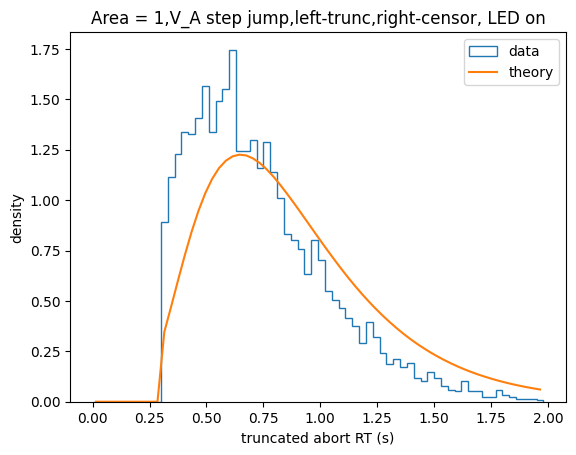

In [111]:
# area = 1

plt.hist(data_abort_rt, bins=bins, density=True, label='data', histtype='step')
plt.plot(t_pts, pdf_ensemble_mean, label='theory')
plt.legend()
plt.xlabel('truncated abort RT (s)')
plt.ylabel('density')

plt.title('Area = 1,V_A step jump,left-trunc,right-censor, LED on')

## how many t_stim < 0.3

Text(0.5, 1.0, 'tstim < 0.3')

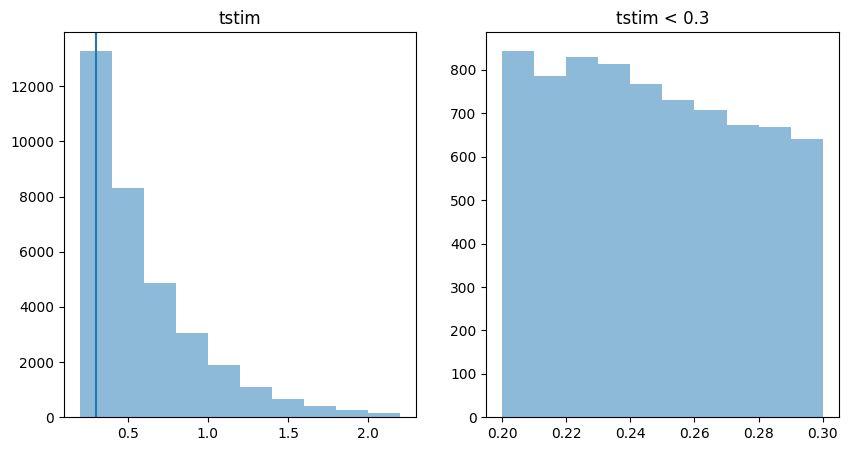

In [94]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df_to_fit['intended_fix'], alpha=0.5);
plt.axvline(T_trunc);
plt.title('tstim')

plt.subplot(1,2,2)
plt.hist(df_to_fit[df_to_fit['intended_fix'] < 0.3]['intended_fix'], alpha=0.5);
plt.title('tstim < 0.3')

# remove t_led = 0

In [95]:
N_theory = 5000
unique_pairs = list(zip(df_to_fit['intended_fix'], df_to_fit['intended_fix'] - df_to_fit['LED_onset_time']))
# from unique_pairs remove rows where second column is zero
unique_pairs = [pair for pair in unique_pairs if pair[1] != 0]

sampled_pairs = random.sample(unique_pairs, min(N_theory, len(unique_pairs)))

pdf_ensemble = np.zeros((N_theory, len(t_pts)))
cdf_ensemble = np.zeros((N_theory, ))
all_areas_pdf_ensemble = np.zeros((N_theory, ))
for i, (t_stim, t_led) in tqdm(enumerate (sampled_pairs), total=N_theory):
    if t_stim <= t_led:
        print('Issue')
        break
    
    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_mean, base_V_A_mean, new_V_A_mean, theta_A_mean, t_led)
    pdf_ensemble[i,:] = [calc_trunc_pdf(t, base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, trunc_factor) for t in t_pts]
    all_areas_pdf_ensemble[i] = np.trapz(pdf_ensemble[i,:], t_pts)
    # if all_areas_pdf_ensemble[i] < 0.8:
    #     print(f'params = {t_stim, t_led}')
    
    cdf_ensemble[i] = calc_trunc_cdf(base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, t_stim, trunc_factor)
    # if cdf_ensemble[i] > 0.2:
    #     print(f'params = {t_stim, t_led}')

100%|██████████| 5000/5000 [03:24<00:00, 24.40it/s]


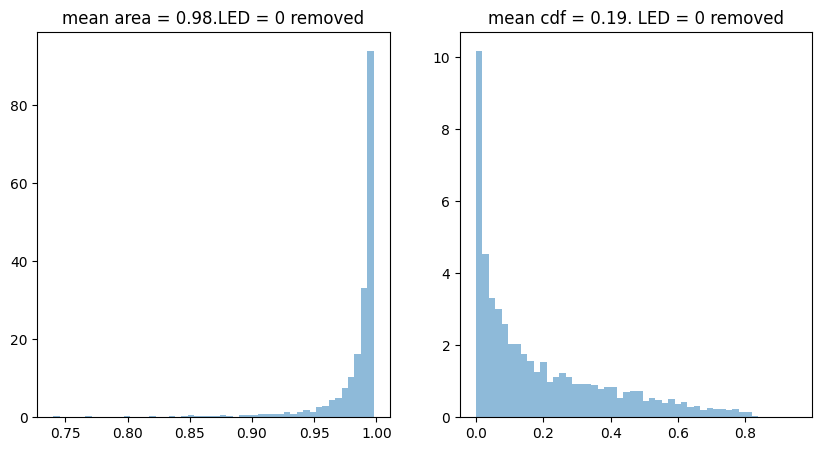

In [96]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(all_areas_pdf_ensemble, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean area = {np.mean(all_areas_pdf_ensemble):.2f}.LED = 0 removed');

plt.subplot(1,2,2)
plt.hist(cdf_ensemble, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean cdf = {np.mean(cdf_ensemble):.2f}. LED = 0 removed');

# led onset distr

In [103]:
led_onset = df_to_fit['intended_fix'] - df_to_fit['LED_onset_time']
num_led_onset_zero = np.sum(led_onset == 0)
print(f'num led onset zero = {num_led_onset_zero}/{len(df_to_fit)}')
print(f'% led onset zero = {100*num_led_onset_zero / len(df_to_fit)}')

num led onset zero = 2475/34025
% led onset zero = 7.274063188831741
